In [1]:
import pandas as pd
import numpy as np
from collections import Counter

#Data Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
sns.set(font_scale=1)
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

from nervaluate import Evaluator
from sklearn.metrics import precision_recall_fscore_support
from seqeval.metrics import classification_report

In [2]:
data = pd.read_csv("../Dataset/annotated_ner_data_new.csv")
data

,token,ner,tweet_id,index
0,Hidup,O,1382601382042103808,0
1,sesedih,O,1382601382042103808,1
2,dan,O,1382601382042103808,2
3,secaper,O,1382601382042103808,3
4,apa,O,1382601382042103808,4
...,...,...,...,...
170065,muntah,O,1386004972207153156,5
170066,Ngabuburit,O,1386301391086309382,0
170067,tadi,O,1386301391086309382,1
170068,sore,O,1386301391086309382,2


In [3]:
data[data.tweet_id == 1382900960721207300]
# data.filter(data["tweet_id"] == 1382900960721207300)

,token,ner,tweet_id,index
170047,renjun,B-PER,1382900960721207300,0
170048,pasti,O,1382900960721207300,1
170049,kamu,O,1382900960721207300,2
170050,beli,O,1382900960721207300,3
170051,anting,O,1382900960721207300,4
170052,antingan,O,1382900960721207300,5
170053,di,O,1382900960721207300,6
170054,abang,O,1382900960721207300,7
170055,maenan,O,1382900960721207300,8
170056,yh,O,1382900960721207300,9


In [4]:
def return_all_entities(data):
    full_entities = []
    prev_tag = "O"
    for index, row in data.iterrows():
        start_tag=row.ner[:1]
        tag= row.ner[2:] if row.ner !='O' else 'O'
        if tag == "O":
            prev_tag = tag
            continue

        if start_tag == 'B': # Begin NE
            full_entities.append([row.token,tag,row.tweet_id])
        elif start_tag == 'I' and prev_tag == tag: # Inside NE
            full_entities[-1][0]  = full_entities[-1][0]+" "+ row.token
        prev_tag = tag

    for row in full_entities:
        row.append(len(row[0].split(" ")))
        
    return pd.DataFrame(full_entities, columns=['token','ner','tweet_id','count_token'])

In [5]:
all_entities=return_all_entities(data)
all_entities

,token,ner,tweet_id,count_token
0,ig,PROD,1382601382042103808,1
1,youtube,PROD,1382601382042103808,1
2,ml,PROD,1382601382042103808,1
3,Nadiem,PER,1384747361994350598,1
4,Megawati,PER,1384747361994350598,1
...,...,...,...,...
14396,PLN,ORG,1383821151986614274,1
14397,PLN,ORG,1383821151986614274,1
14398,Sahar,PER,1383821151986614274,1
14399,renjun,PER,1382900960721207300,1


In [6]:
dict(all_entities.ner.value_counts())

{'PER': 5564, 'PROD': 3554, 'LOC': 2225, 'ORG': 2085, 'EV': 809, 'WA': 164}

In [7]:
#count token length of a entity level tag 
dict(all_entities.count_token.value_counts())

{1: 9335,
 2: 3626,
 3: 987,
 4: 256,
 5: 91,
 6: 41,
 7: 28,
 8: 16,
 11: 8,
 9: 8,
 14: 1,
 10: 1,
 16: 1,
 15: 1,
 12: 1}

In [8]:
#show all tweet that contains exactly 5 NEs 
# all_entities[(all_entities.count_token==5) and (all_entities.ner=='LOC')]

In [9]:
#data.groupby('tweet_id').size().reset_index(name='token')

In [10]:
data.loc[data['ner'] == 'B-PER', 'token']

31             Nadiem
37           Megawati
89        @daya_hadid
129             Anies
134              Ahok
             ...     
169995         Ridwan
170013       Megawati
170041          Sahar
170047         renjun
170059         renjun
Name: token, Length: 5564, dtype: object

In [11]:
data.groupby('ner').size().reset_index(name='count tag')
# data[data.tweet_id==1382900960721207300]

,ner,count tag
0,B-EV,809
1,B-LOC,2225
2,B-ORG,2085
3,B-PER,5564
4,B-PROD,3554
5,B-WA,164
6,I-EV,978
7,I-LOC,957
8,I-ORG,1124
9,I-PER,3058


d:\Drive\KULEEAH\Semester 8\TA Farihin\env\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


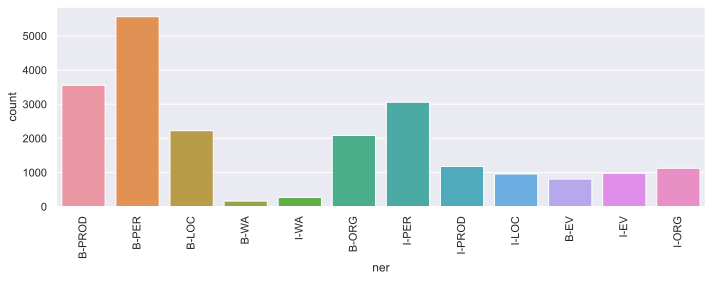

In [12]:
#Words distribution across Tags without O tag
plt.figure(figsize=(10, 4))
ax = sns.countplot('ner', data=data.loc[data['ner'] != 'O'])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="center")
plt.tight_layout()
plt.show()

In [13]:
class getsentence(object):
    
    def __init__(self, data):
        self.n_sent = 1.0
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, t) for w, t in zip(s["token"].values.tolist(),
                                                     s["ner"].values.tolist())]
        self.grouped = self.data.groupby("tweet_id").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [14]:
getter = getsentence(data)
sentences = getter.sentences
#This is how a sentence will look like. 
print(sentences[:1])

[[('@ridwankamil', 'O'), ('@KickAndyShow', 'O'), ('@Metro_TV', 'O'), ('Upaya', 'O'), ('untuk', 'O'), ('mnaikan', 'O'), ('nilai', 'O'), ('jual', 'O'), ('yg', 'O'), ('bgus,dngn', 'O'), ('cara', 'O'), ('d', 'O'), ('desain', 'O'), ('pak', 'O'), ('gubernur', 'B-PER'), ('akan', 'O'), ('menjadikn', 'O'), ('produk', 'O'), ('umkm', 'O'), ('d', 'O'), ('mintai', 'O'), ('krena', 'O'), ('yg', 'O'), ('desain', 'O'), ('org', 'O'), ('nomer', 'O'), ('satu', 'O'), ('di', 'O'), ('jabar', 'B-LOC')]]


In [15]:
words = list(set(data["token"].values))
n_words = len(words)
print(n_words)

35418


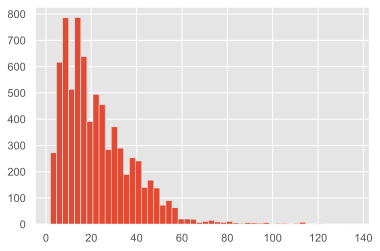

In [16]:
#Lets visualize how the sentences are distributed by their length
plt.style.use("ggplot")
plt.hist([len(s) for s in sentences], bins=50)
plt.show()

In [17]:
def find_consecutive_ne(sentence):
    full_entities = []
    prev_tag = "O"
    for token, full_tag in sentence:
        start_tag=full_tag[:1]
        tag= full_tag[2:] if full_tag!='O' else 'O'
        if tag == "O":
            prev_tag = tag
            continue

        if start_tag == 'B': # Begin NE
            full_entities.append([token,tag])
        elif start_tag == 'I' and prev_tag == tag: # Inside NE
            full_entities[-1][0]  = full_entities[-1][0]+" "+ token
        prev_tag = tag
    return full_entities

def count_ne(sentence):
    counter={
        'PER':0,
        'LOC':0,
        'ORG':0,
        'PROD':0,
        'WA':0,
        'EV':0
    }
    for _, tag in sentence:
        counter[tag]+=1
    return counter

In [18]:
full_tag = [find_consecutive_ne(s) for s in sentences]

In [19]:
find_consecutive_ne(sentences[11])

[['Erick Thohir', 'PER'],
 ['Ridwan Kamil', 'PER'],
 ['Pertashop', 'PROD'],
 ['Lembang', 'LOC'],
 ['ANTARA News Jawa Barat', 'ORG']]

In [20]:
count_ne(find_consecutive_ne(sentences[11]))

{'PER': 2, 'LOC': 1, 'ORG': 1, 'PROD': 1, 'WA': 0, 'EV': 0}

In [21]:
# TODO
# 1) Bikin line chart. Nyari distribusi frekuensi entitas, misal bikin ky zipf law, seberapa unik entitas tersebut.
# 2) Statistika Panjang entitas multi word, tampilin dalam table, misal max mean median. Atau bikin box plot.
# 3) Tabel perbandingan proporsi jumlah tag (train-test val) tambahin yg perentitas, jadi bukan B-PER tapi PER. 
# 4) Hitung OOV rate dari data test. Jadi kemampuan model buat baca antara oov dengan tidak oov. Bisa ga model buat. Coba save hasil prediksinya.

1) Bikin line chart. Nyari distribusi frekuensi entitas, misal bikin ky zipf law, seberapa unik entitas tersebut.


In [22]:
kemunculan_entitas_per= all_entities[all_entities.ner=='PER'].token.value_counts()
kemunculan_entitas_loc= all_entities[all_entities.ner=='LOC'].token.value_counts()
kemunculan_entitas_org= all_entities[all_entities.ner=='ORG'].token.value_counts()
kemunculan_entitas_prod= all_entities[all_entities.ner=='PROD'].token.value_counts()
kemunculan_entitas_wa= all_entities[all_entities.ner=='WA'].token.value_counts()
kemunculan_entitas_ev= all_entities[all_entities.ner=='EV'].token.value_counts()

In [23]:
sum(kemunculan_entitas_per)

5564

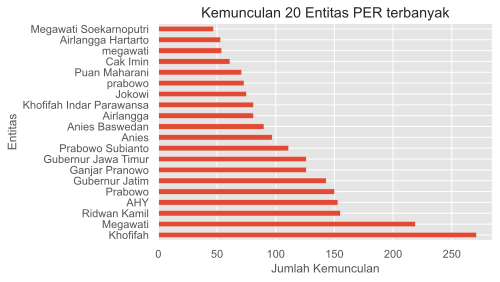

In [24]:
kemunculan_entitas_per[:20].plot(kind = 'barh')
plt.title("Kemunculan 20 Entitas PER terbanyak")
plt.xlabel("Jumlah Kemunculan")
plt.ylabel("Entitas")
plt.savefig('../kemunculan_entitas_per.png', bbox_inches='tight')

In [25]:
sum(kemunculan_entitas_loc)

2225

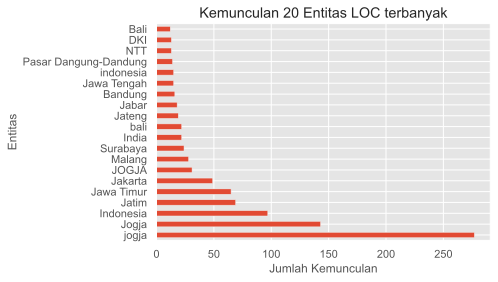

In [26]:
kemunculan_entitas_loc[:20].plot(kind = 'barh')
plt.title("Kemunculan 20 Entitas LOC terbanyak")
plt.xlabel("Jumlah Kemunculan")
plt.ylabel("Entitas")
plt.savefig('../kemunculan_entitas_loc.png', bbox_inches='tight')

In [27]:
sum(kemunculan_entitas_org)

2085

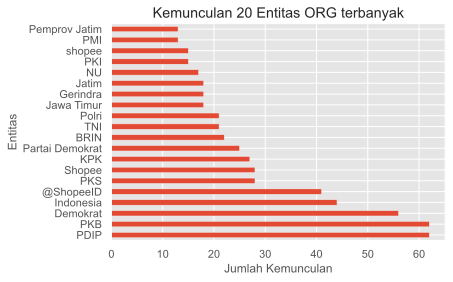

In [28]:
kemunculan_entitas_org[:20].plot(kind = 'barh')
plt.title("Kemunculan 20 Entitas ORG terbanyak")
plt.xlabel("Jumlah Kemunculan")
plt.ylabel("Entitas")
plt.savefig('../kemunculan_entitas_org.png', bbox_inches='tight')

In [29]:
sum(kemunculan_entitas_prod)

3554

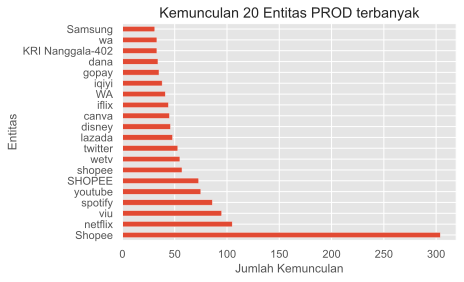

In [30]:
kemunculan_entitas_prod[:20].plot(kind = 'barh')
plt.title("Kemunculan 20 Entitas PROD terbanyak")
plt.xlabel("Jumlah Kemunculan")
plt.ylabel("Entitas")
plt.savefig('../kemunculan_entitas_prod.png', bbox_inches='tight')

In [31]:
sum(kemunculan_entitas_wa)

164

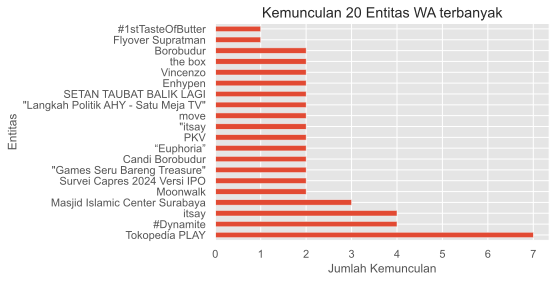

In [32]:
kemunculan_entitas_wa[:20].plot(kind = 'barh')
plt.title("Kemunculan 20 Entitas WA terbanyak")
plt.xlabel("Jumlah Kemunculan")
plt.ylabel("Entitas")
plt.savefig('../kemunculan_entitas_wa.png', bbox_inches='tight')

In [33]:
sum(kemunculan_entitas_ev)

809

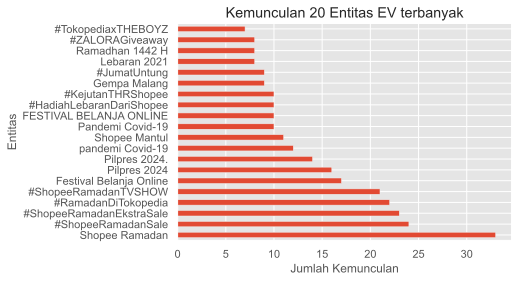

In [34]:
kemunculan_entitas_ev[:20].plot(kind = 'barh')
plt.title("Kemunculan 20 Entitas EV terbanyak")
plt.xlabel("Jumlah Kemunculan")
plt.ylabel("Entitas")
plt.savefig('../kemunculan_entitas_ev.png', bbox_inches='tight')

d:\Drive\KULEEAH\Semester 8\TA Farihin\env\lib\site-packages\matplotlib\backends\backend_agg.py:240: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0.0, flags=flags)
d:\Drive\KULEEAH\Semester 8\TA Farihin\env\lib\site-packages\matplotlib\backends\backend_agg.py:203: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0, flags=flags)
d:\Drive\KULEEAH\Semester 8\TA Farihin\env\lib\site-packages\matplotlib\textpath.py:65: RuntimeWarning: Glyph 65533 missing from current font.
  font.set_text(s, 0.0, flags=LOAD_NO_HINTING)


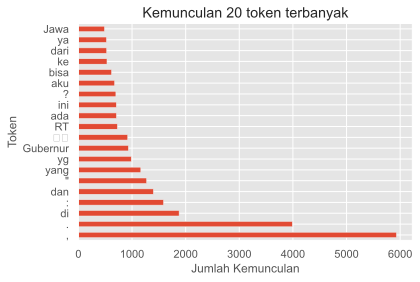

In [35]:
data.token.value_counts()[:20].plot(kind = 'barh')
plt.title("Kemunculan 20 token terbanyak")
plt.xlabel("Jumlah Kemunculan")
plt.ylabel("Token")
plt.savefig('../kemunculan_entitas_all.png', bbox_inches='tight')

2) Statistika Panjang entitas multi word, tampilin dalam table, misal max mean median. Atau bikin box plot.


count    14401.000000
mean         1.515450
std          0.929038
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         16.000000
Name: count_token, dtype: float64


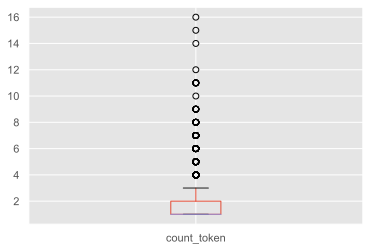

In [36]:
all_entities.boxplot(['count_token'])
plt.savefig('../boxplot_jumlah_token_entitas.png', bbox_inches='tight')
print(all_entities.count_token.describe())

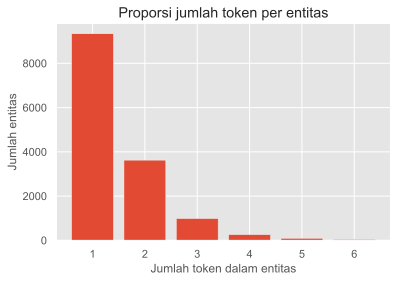

In [37]:
fig, ax = plt.subplots()
plot_value_counts=dict(all_entities.count_token.value_counts()[:6])
rects1 = ax.bar(plot_value_counts.keys(), plot_value_counts.values())
ax.set_xlabel('Jumlah token dalam entitas')
ax.set_ylabel('Jumlah entitas')
ax.set_title('Proporsi jumlah token per entitas')
fig.savefig('../jumlah_token_entitas.png', bbox_inches='tight')
# all_entities.plot(kind = 'bar',x=,y=)

3) Tabel perbandingan proporsi jumlah tag (train-test val) tambahin yg perentitas, jadi bukan B-PER tapi PER. 


In [38]:
train_df =pd.read_csv("..\Dataset\\simpletransformers\\train.csv")
eval_df =pd.read_csv("..\Dataset\\simpletransformers\\val.csv")
test_df =pd.read_csv("..\Dataset\\simpletransformers\\test.csv")

In [39]:
train_df

,sentence_id,words,labels
0,1380681275594305537,@ridwankamil,O
1,1380681275594305537,@KickAndyShow,O
2,1380681275594305537,@Metro_TV,O
3,1380681275594305537,Upaya,O
4,1380681275594305537,untuk,O
...,...,...,...
109513,1389452349618327554,^^,O
109514,1389452349618327554,��dm,O
109515,1389452349618327554,for,O
109516,1389452349618327554,order,O


In [40]:
def return_all_entities_df(data):
    full_entities = []
    prev_tag = "O"
    for index, row in data.iterrows():
        start_tag=row.labels[:1]
        tag= row.labels[2:] if row.labels !='O' else 'O'
        if tag == "O":
            prev_tag = tag
            continue

        if start_tag == 'B': # Begin NE
            full_entities.append([row.words,tag,row.sentence_id])
        elif start_tag == 'I' and prev_tag == tag: # Inside NE
            full_entities[-1][0]  = full_entities[-1][0]+" "+ row.words
        prev_tag = tag

    for row in full_entities:
        row.append(len(row[0].split(" ")))
        
    return pd.DataFrame(full_entities, columns=['token','ner','tweet_id','count_token'])

In [41]:
train_df_all_entities=return_all_entities_df(train_df)
eval_df_all_entities=return_all_entities_df(eval_df)
test_df_all_entities=return_all_entities_df(test_df)

In [42]:
labels = list(train_df_all_entities.ner.value_counts().keys())
train_val_count=pd.DataFrame(train_df_all_entities.ner.value_counts()).loc[labels,:]
eval_val_count=pd.DataFrame(eval_df_all_entities.ner.value_counts()).loc[labels,:]
test_val_count=pd.DataFrame(test_df_all_entities.ner.value_counts()).loc[labels,:]

In [43]:
train_val_count['class'] = 'Train'
eval_val_count['class'] = 'Val'
test_val_count['class'] = 'Test'

merged_val_count= pd.concat([train_val_count, eval_val_count, test_val_count])
merged_val_count['tag']=merged_val_count.index
merged_val_count.rename(columns={'ner':'count'},inplace=True)
merged_val_count.reset_index(drop=True, inplace=True)

In [44]:
merged_val_count

,count,class,tag
0,3694,Train,PER
1,2270,Train,PROD
2,1455,Train,LOC
3,1388,Train,ORG
4,524,Train,EV
5,99,Train,WA
6,949,Val,PER
7,465,Val,PROD
8,336,Val,LOC
9,346,Val,ORG


In [45]:
for i in ['PER','PROD', 'LOC', 'ORG', 'EV', 'WA']:
    merged_val_count.loc[merged_val_count.tag==i, "count"] = merged_val_count['count']*100/sum(merged_val_count.loc[merged_val_count.tag==i]['count'])


In [46]:
merged_val_count

,count,class,tag
0,63.788638,Train,PER
1,66.549399,Train,PROD
2,65.305206,Train,LOC
3,65.379180,Train,ORG
4,65.829146,Train,EV
5,63.057325,Train,WA
6,16.387498,Val,PER
7,13.632366,Val,PROD
8,15.080790,Val,LOC
9,16.297692,Val,ORG


In [47]:
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.1f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.1f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

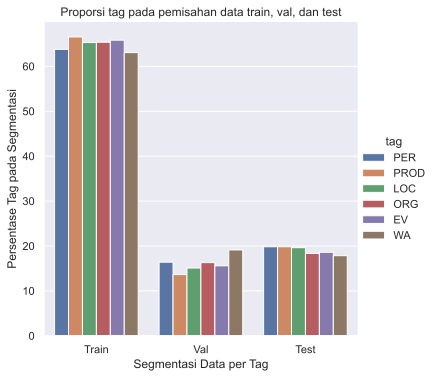

In [48]:
sns.set(rc={"figure.dpi":300, 'savefig.dpi':300})
ax = sns.catplot(x='class', y='count', hue='tag',
            data=merged_val_count, kind='bar'
            )
ax.set(
        title="Proporsi tag pada pemisahan data train, val, dan test",
        xlabel="Segmentasi Data per Tag",
        ylabel="Persentase Tag pada Segmentasi",
        )
plt.savefig('../proporsi_entitas_split.png', bbox_inches='tight')
# show_values(ax)

4) Hitung OOV rate dari data test. Jadi kemampuan model buat baca antara oov dengan tidak oov. Bisa ga model buat. Coba save hasil prediksinya.


In [49]:
train_token= list(train_df.words)
eval_token=  list(eval_df.words)
test_token=  list(test_df.words)
oov_all_eval_list = [i for i in eval_token if i not in train_token ]
oov_all_test_list = [i for i in test_token if i not in train_token ]

In [50]:
print(
    len(train_token),
    len(eval_token),
    len(test_token),
    len(oov_all_eval_list),
    len(oov_all_test_list)
)

109518 27180 33814 4974 2263


In [177]:
# with open ("simpletransformers\\3_indobert_large_p1\\results_test_pred.txt", "r",encoding="utf-8") as myfile:
# with open ("simpletransformers\\5_bert_base_cased\\results_test_pred.txt", "r",encoding="utf-8") as myfile:
with open ("simpletransformers\\6_bert_base_multilingual_cased\\results_test_pred.txt", "r",encoding="utf-8") as myfile:
    results_test_pred=myfile.readlines()
results_test_pred=eval(results_test_pred[0])

results_oov=list()
results_non_oov=list()

for tweet in results_test_pred:
    temp_oov=list()
    temp_non_oov=list()
    for tok in tweet:
        if tok[0] not in train_token:
            temp_oov.append(tok)
        if tok[0] in train_token:
            temp_non_oov.append(tok)
    results_oov.append(temp_oov)
    results_non_oov.append(temp_non_oov)

### OOV data

In [171]:
y_test_oov=list()
y_pred_oov=list()
for tweet in results_oov:
    ytest_temp=list()
    ypred_temp=list()
    for tok in tweet:
        ytest_temp.append(tok[1])
        ypred_temp.append(tok[2])
    y_test_oov.append(ytest_temp)
    y_pred_oov.append(ypred_temp)

In [172]:
print(classification_report(y_test_oov,y_pred_oov,digits=3))

              precision    recall  f1-score   support

          EV      0.400     0.100     0.160        20
         LOC      0.594     0.514     0.551        37
         ORG      0.343     0.293     0.316        41
         PER      0.597     0.361     0.450       119
        PROD      0.224     0.295     0.255        44
          WA      0.500     0.125     0.200         8

   micro avg      0.441     0.335     0.381       269
   macro avg      0.443     0.281     0.322       269
weighted avg      0.479     0.335     0.383       269



In [133]:
oov_evaluator = Evaluator(y_test_oov, y_pred_oov, tags=['LOC', 'PER', 'ORG', 'PROD', 'WA', 'EV'], loader="list")

In [134]:
oov_results, oov_results_per_tag = oov_evaluator.evaluate()

In [135]:
oov_results['partial']

{'correct': 145,
 'incorrect': 0,
 'partial': 6,
 'missed': 121,
 'spurious': 51,
 'possible': 272,
 'actual': 202,
 'precision': 0.7326732673267327,
 'recall': 0.5441176470588235,
 'f1': 0.6244725738396624}

In [136]:
oov_results['exact']

{'correct': 145,
 'incorrect': 6,
 'partial': 0,
 'missed': 121,
 'spurious': 51,
 'possible': 272,
 'actual': 202,
 'precision': 0.7178217821782178,
 'recall': 0.5330882352941176,
 'f1': 0.6118143459915613}

In [137]:
from operator import itemgetter


for i in ['LOC', 'PER', 'ORG', 'PROD', 'WA', 'EV']:
    for j in ['partial','exact']:
        if j=='partial':
            print(str(itemgetter('precision','recall','f1')(oov_results_per_tag[i][j]))[1:-1],end=', ')
        else:
            print(str(itemgetter('precision','recall','f1')(oov_results_per_tag[i][j]))[1:-1])

0.7833333333333333, 0.618421052631579, 0.6911764705882353, 0.7666666666666667, 0.6052631578947368, 0.676470588235294
0.8, 0.5619834710743802, 0.6601941747572815, 0.788235294117647, 0.5537190082644629, 0.6504854368932039
0.7027027027027027, 0.6341463414634146, 0.6666666666666667, 0.7027027027027027, 0.6341463414634146, 0.6666666666666667
0.6052631578947368, 0.5227272727272727, 0.5609756097560975, 0.6052631578947368, 0.5227272727272727, 0.5609756097560975
0.5, 0.25, 0.3333333333333333, 0.25, 0.125, 0.16666666666666666
0.6875, 0.275, 0.3928571428571429, 0.625, 0.25, 0.35714285714285715


### non oov data

In [178]:
y_test_non_oov=list()
y_pred_non_oov=list()
for tweet in results_non_oov:
    ytest_temp=list()
    ypred_temp=list()
    for tok in tweet:
        ytest_temp.append(tok[1])
        ypred_temp.append(tok[2])
    y_test_non_oov.append(ytest_temp)
    y_pred_non_oov.append(ypred_temp)

In [179]:
print(classification_report(y_test_non_oov,y_pred_non_oov,digits=3))

              precision    recall  f1-score   support

          EV      0.686     0.671     0.679       140
         LOC      0.919     0.928     0.924       418
         ORG      0.874     0.815     0.843       367
         PER      0.960     0.925     0.942      1045
        PROD      0.906     0.921     0.914       648
          WA      0.474     0.346     0.400        26

   micro avg      0.910     0.890     0.900      2644
   macro avg      0.803     0.768     0.784      2644
weighted avg      0.909     0.890     0.899      2644



In [165]:
non_oov_evaluator = Evaluator(y_test_non_oov, y_pred_non_oov, tags=['LOC', 'PER', 'ORG', 'PROD', 'WA', 'EV'], loader="list")

In [166]:
non_oov_results, non_oov_results_per_tag = non_oov_evaluator.evaluate()

In [167]:
print(str(itemgetter('precision','recall','f1')(non_oov_results['partial']))[1:-1], end = ', ')
print(str(itemgetter('precision','recall','f1')(non_oov_results['exact']))[1:-1])


0.9278919330289194, 0.9222768532526475, 0.9250758725341427, 0.908675799086758, 0.903177004538578, 0.9059180576631258


In [168]:
from operator import itemgetter

for i in ['LOC', 'PER', 'ORG', 'PROD', 'WA', 'EV']:
    for j in ['partial','exact']:
        # temp[(i,j)]=itemgetter('precision','recall','f1')(non_oov_results_per_tag[i][j])
        if j=='partial':
            print(str(itemgetter('precision','recall','f1')(non_oov_results_per_tag[i][j]))[1:-1],end=', ')
        else:
            print(str(itemgetter('precision','recall','f1')(non_oov_results_per_tag[i][j]))[1:-1])


0.9302600472813238, 0.9413875598086124, 0.9357907253269916, 0.9030732860520094, 0.9138755980861244, 0.9084423305588586
0.966275659824047, 0.945933014354067, 0.9559961315280465, 0.9608993157380255, 0.9406698564593301, 0.9506769825918762
0.8977591036414566, 0.8732970027247956, 0.8853591160220994, 0.865546218487395, 0.8419618528610354, 0.8535911602209945
0.9446153846153846, 0.9475308641975309, 0.9460708782742681, 0.9307692307692308, 0.933641975308642, 0.9322033898305085
0.6875, 0.6346153846153846, 0.6599999999999999, 0.5, 0.46153846153846156, 0.48000000000000004
0.6986754966887417, 0.7535714285714286, 0.7250859106529208, 0.6423841059602649, 0.6928571428571428, 0.6666666666666666


### all data

In [145]:
y_test=list()
y_pred=list()
for tweet in results_test_pred:
    ytest_temp=list()
    ypred_temp=list()
    for tok in tweet:
        ytest_temp.append(tok[1])
        ypred_temp.append(tok[2])
    y_test.append(ytest_temp)
    y_pred.append(ypred_temp)

In [146]:
print(classification_report(y_test,y_pred,digits=3))

              precision    recall  f1-score   support

          EV      0.667     0.618     0.642       152
         LOC      0.896     0.898     0.897       442
         ORG      0.833     0.784     0.808       394
         PER      0.943     0.877     0.909      1150
        PROD      0.881     0.894     0.888       689
          WA      0.435     0.333     0.377        30

   micro avg      0.886     0.852     0.869      2857
   macro avg      0.776     0.734     0.753      2857
weighted avg      0.886     0.852     0.868      2857



In [147]:
df=[(i, k[0],k[1], k[2]) for i, j in enumerate(results_test_pred) for k in j]
df = pd.DataFrame(df, columns = ['id', 'token', 'label', 'pred'])